## PAYMENT FRAUD RISK SCORE.
 
This **project** aims to enhance the security and reliability of payment systems processing system.

In [231]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')

In [364]:
def wrangle(file_path):
    df = pd.read_csv(file_path).set_index('Transaction_ID')
    
    # removing outiers frrom the data
    low, high = df['New_Balance'].quantile([0.1, 0.9])
    
    mask = df['New_Balance'].between(low, high)
    
    df = df[mask]
    
    # removing colus that are not impactful to the model.
    df.drop(columns=['Transaction_Date', 'Transaction_Time', 'Gender', 'Currency'],  inplace=True)
    
    return df

In [365]:
df = wrangle(r'C:\Users\gbest\Desktop\Payment_Fraud_Risk.csv')
print('df shape:', df.shape)
df.head()

df shape: (25831, 6)


,Old_Balance,Transaction_Amount,New_Balance,Transaction_Type,Merchant_Category,Is_Fraud
Transaction_ID,,,,,,
9.441203e+08,160724,10500.0,150224.0,ATM_Withdral,Retail,0
3.000937e+09,131273,17500.0,113773.0,Online_Purchase,Financial Services,0
2.881284e+09,272780,100000.0,172780.0,Online_Purchase,Financial Services,1
2.499991e+09,91666,13500.0,78166.0,Online_Purchase,Financial Services,1
2.734721e+10,122999,23400.0,99599.0,Online_Purchase,Financial Services,1


### Before building the model, it will be a great idea to go through data and see what information to can uncover.
Exploratory Data Analysis **(EDA)**

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 25831 entries, 944120304.0 to 19013123823.0
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Old_Balance         25831 non-null  int64  
 1   Transaction_Amount  25830 non-null  float64
 2   New_Balance         25831 non-null  float64
 3   Transaction_Type    25831 non-null  object 
 4   Merchant_Category   25831 non-null  object 
 5   Is_Fraud            25831 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


- The data we are working with do not have any null value.

In [306]:
df['Gender'].value_counts()

M    19221
F    13068
Name: Gender, dtype: int64

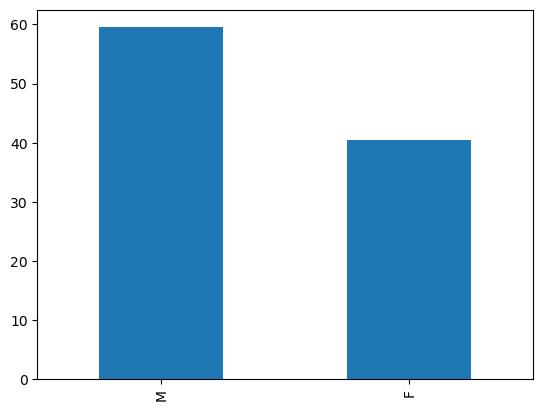

In [307]:
((df['Gender'].value_counts(normalize=True))* 100).plot(kind='bar');

* Data show that there are more male use quickteller to transact than female

### Gender Vs Transaction Amount

In [308]:
male = df['Gender'] == 'M'
df[male]

,Transaction_Date,Transaction_Time,Gender,Currency,Old_Balance,Transaction_Amount,New_Balance,Transaction_Type,Merchant_Category,Is_Fraud
Transaction_ID,,,,,,,,,,
9.441203e+08,6/1/2022,1:21:00,M,NG,160724,10500.0,150224.0,ATM_Withdral,Retail,0
3.000937e+09,6/1/2022,4:53:00,M,NG,131273,17500.0,113773.0,Online_Purchase,Financial Services,0
3.140681e+10,6/1/2022,4:53:00,M,NG,4012723,66000.0,3946723.0,Online_Purchase,Financial Services,0
1.347741e+09,6/1/2022,5:58:00,M,NG,30461,12000.0,18461.0,Online_Purchase,Financial Services,0
2.499991e+09,6/1/2022,8:59:00,M,NG,91666,13500.0,78166.0,Online_Purchase,Financial Services,1
...,...,...,...,...,...,...,...,...,...,...
2.703329e+08,12/31/2022,11:57:00,M,NG,343123,12500.0,330623.0,Online_Purchase,Clothing,0
9.069243e+08,12/31/2022,11:56:00,M,NG,98101,4500.0,93601.0,Online_Purchase,Financial Services,0
2.686902e+09,12/31/2022,10:53:00,M,NG,84790,3000.0,81790.0,ATM_Withdral,Financial Services,0


In [309]:
df['Transaction_Type'].unique()

array(['ATM_Withdral', 'Online_Purchase'], dtype=object)

In [310]:
df[male]['Transaction_Amount'].sum()

90525023.484848

In [311]:
male = df['Gender'] == 'M'
male_trans = df['Transaction_Type'] == 'ATM_Withdral'

df[male & male_trans]['Transaction_Amount'].sum()

41637789.191919

In [312]:
male = df['Gender'] == 'M'
male_trans = df['Transaction_Type'] == 'Online_Purchase'

df[male & male_trans]['Transaction_Amount'].sum()

48887234.292929

The male users did transactions worth over 90million naira.
* 41,637,789 million naira of this transaction was done using the ATM.
* 48,887,234 million naira of this transaction was done using mobile app.

In [353]:
female = df['Gender'] == 'F'
df[female]

,Transaction_Date,Transaction_Time,Gender,Currency,Old_Balance,Transaction_Amount,New_Balance,Transaction_Type,Merchant_Category,Is_Fraud
Transaction_ID,,,,,,,,,,
2.881284e+09,6/1/2022,8:59:00,F,NG,272780,100000.0,172780.0,Online_Purchase,Financial Services,1
2.734721e+10,6/1/2022,9:15:00,F,NG,122999,23400.0,99599.0,Online_Purchase,Financial Services,1
2.840000e+11,6/1/2022,11:06:00,F,NG,1837312,2000.0,1835312.0,ATM_Withdral,Financial Services,0
1.280000e+11,6/1/2022,11:27:00,F,NG,449432,3000.0,446432.0,Online_Purchase,Financial Services,0
2.326397e+10,6/1/2022,10:02:00,F,NG,234320,4000.0,230320.0,ATM_Withdral,Clothing,0
...,...,...,...,...,...,...,...,...,...,...
2.812803e+09,12/31/2022,11:57:00,F,NG,306982,3000.0,303982.0,ATM_Withdral,Retail,0
1.331443e+09,12/31/2022,10:53:00,F,NG,36020,3000.0,33020.0,Online_Purchase,Financial Services,0
3.044786e+10,12/31/2022,11:26:00,F,NG,122246,12500.0,109746.0,Online_Purchase,Retail,0


In [313]:
female = df['Gender'] == 'F'
df[female]['Transaction_Amount'].sum()

61879633.232323006

In [276]:
female = df['Gender'] == 'F'
female_trans = df['Transaction_Type'] == 'ATM_Withdral'

df[female & female_trans]['Transaction_Amount'].sum()

28646387.474748

In [277]:
female = df['Gender'] == 'F'
female_trans = df['Transaction_Type'] == 'Online_Purchase'

df[female & female_trans]['Transaction_Amount'].sum()

33233245.757574998

The male users did transaction worth over 61,879,633 million naira.
* 28,646,387 million naira of this transaction was done using the ATM.
* 33,233,245 million naira of this transaction was done using mobile app.

### merchant Category Vs Transaction.

In [278]:
df['Merchant_Category'].value_counts(normalize=True)

 Financial Services      0.272384
Airtime Top-up           0.133048
Betting and Lottery      0.086005
Cable Subscription       0.078541
Event Ticket             0.060392
School Fees              0.059122
prepaid Card Services    0.051751
Travel and Hotel         0.049119
Utilities                0.039549
Product and Services     0.039208
Mobile Money             0.034067
 Clothing                0.031497
Invoice Payment          0.028338
Shopping                 0.023599
 Retail                  0.010158
 Electronics             0.003221
Name: Merchant_Category, dtype: float64

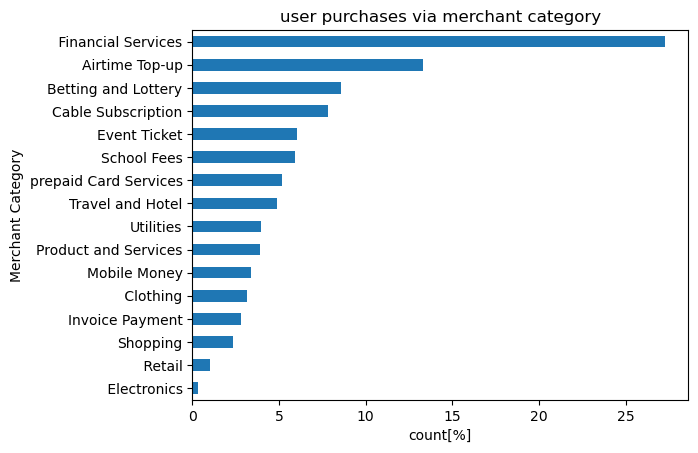

In [279]:
(df['Merchant_Category'].value_counts(normalize=True)*100).sort_values().plot(kind='barh')
plt.xlabel('count[%]')
plt.ylabel('Merchant Category')
plt.title('user purchases via merchant category');

In [280]:
fin_ser = df['Merchant_Category'] == ' Financial Services'
df[fin_ser]['Transaction_Amount'].sum().round(2)

39921427.47

In [281]:
airtime = df['Merchant_Category'] == 'Airtime Top-up'
df[airtime]['Transaction_Amount'].sum().round(2)

18527667.78

In [282]:
bet = df['Merchant_Category'] == 'Betting and Lottery'
df[bet]['Transaction_Amount'].sum().round(2)

15066602.32

In [283]:
cable_sub = df['Merchant_Category'] == 'Cable Subscription'
df[cable_sub]['Transaction_Amount'].sum().round(2)

10790844.7

In [284]:
event = df['Merchant_Category'] == 'Event Ticket'
df[event]['Transaction_Amount'].sum().round(2)

10437532.32

In [285]:
s_fee = df['Merchant_Category'] == 'School Fees'
df[s_fee]['Transaction_Amount'].sum().round(2)

9452115.15

In [286]:
t_h = df['Merchant_Category'] == 'Travel and Hotel'
df[t_h]['Transaction_Amount'].sum().round(2)

6466129.55

In [287]:
pre_ser = df['Merchant_Category'] == 'prepaid Card Services'
df[pre_ser]['Transaction_Amount'].sum().round(2)

10140770.0

In [288]:
utils = df['Merchant_Category'] == 'Utilities'
df[utils]['Transaction_Amount'].sum().round(2)

6471138.38

In [289]:
prod_ser = df['Merchant_Category'] == 'Product and Services'
df[prod_ser]['Transaction_Amount'].sum().round(2)

5917883.33

In [290]:
mob_mny = df['Merchant_Category'] == 'Mobile Money'
df[mob_mny]['Transaction_Amount'].sum().round(2)

2859477.78

In [291]:
clot = df['Merchant_Category'] == ' Clothing'
df[clot]['Transaction_Amount'].sum().round(2)

4733202.27

In [292]:
inv_pay = df['Merchant_Category'] == 'Invoice Payment'
df[inv_pay]['Transaction_Amount'].sum().round(2)

4838765.66

In [293]:
shop = df['Merchant_Category'] == 'Shopping'
df[shop]['Transaction_Amount'].sum().round(2)

4741700.0

In [294]:
retail = df['Merchant_Category'] == ' Retail'
df[retail]['Transaction_Amount'].sum().round(2)

1557250.0

In [295]:
elect = df['Merchant_Category'] == ' Electronics'
df[elect]['Transaction_Amount'].sum().round(2)

482150.0

* The Diagram and details above shows vividly how much and on what our users used the found in there account to purchase or do.




## Transaction Amount

In [300]:
df['New_Balance'].describe().apply("{0:,.0f}".format)

count         32,289
mean         862,821
std        3,527,605
min          -29,009
25%          107,932
50%          187,199
75%          366,200
max      312,809,812
Name: New_Balance, dtype: object

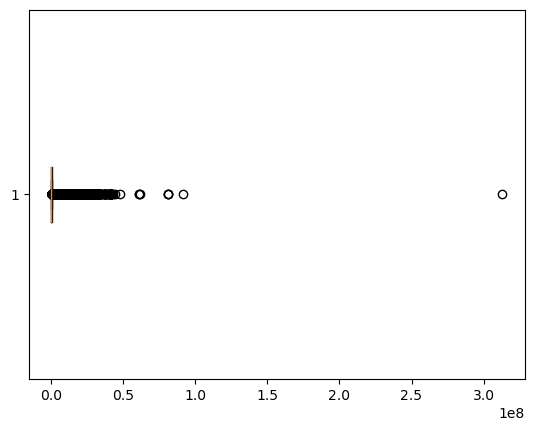

In [302]:
plt.boxplot(df['New_Balance'], vert=False);

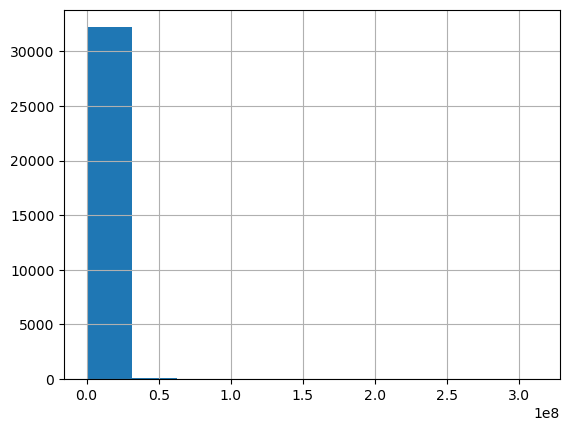

In [363]:
df['New_Balance'].hist();

* The transaction amount has outlier and we have to removing it before building the model

In [299]:
# low, high = df['Transaction_Amount'].quantile([0.1, 0.9])
# mask = df['Transaction_Amount'].between(low, high)

In [319]:
df['New_Balance'].describe().apply("{0:,.0f}".format)

count       25,831
mean       345,769
std        438,730
min         22,723
25%        120,168
50%        187,199
75%        301,950
max      1,912,126
Name: New_Balance, dtype: object

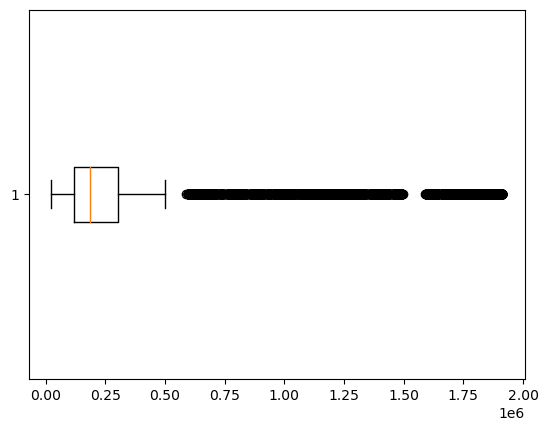

In [320]:
plt.boxplot(df['New_Balance'], vert=False);

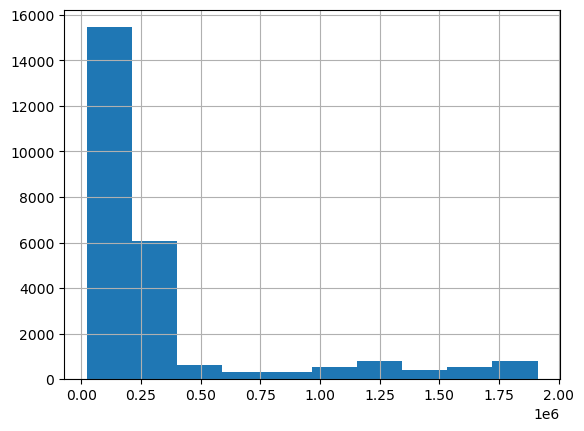

In [360]:
df['New_Balance'].hist();

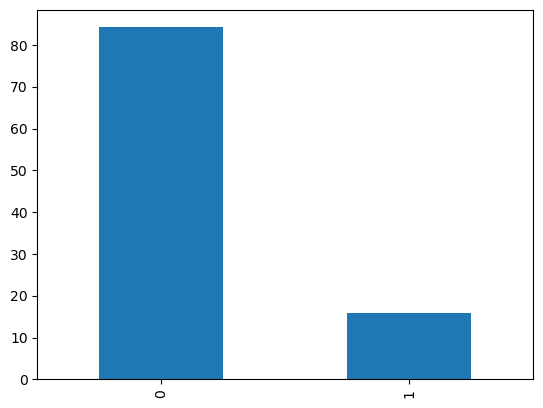

In [129]:
((df['Is_Fraud'].value_counts(normalize=True))* 100).plot(kind='bar');

### fraudlent activity
* the `is_fraud` column has over 84.% (0) which stands `no fraudlent activity`.
* the `is_fraud` column has over 15.% (1) which stands `fraudlent activity`.

## Splitting the data for model building.

In [322]:
target = 'Is_Fraud'

y = df[target]
X = df.drop(columns=[target])

print(y.head())
X.head()

Transaction_ID
9.441203e+08    0
3.000937e+09    0
2.881284e+09    1
2.499991e+09    1
2.734721e+10    1
Name: Is_Fraud, dtype: int64


,Old_Balance,Transaction_Amount,New_Balance,Transaction_Type,Merchant_Category
Transaction_ID,,,,,
9.441203e+08,160724,10500.0,150224.0,ATM_Withdral,Retail
3.000937e+09,131273,17500.0,113773.0,Online_Purchase,Financial Services
2.881284e+09,272780,100000.0,172780.0,Online_Purchase,Financial Services
2.499991e+09,91666,13500.0,78166.0,Online_Purchase,Financial Services
2.734721e+10,122999,23400.0,99599.0,Online_Purchase,Financial Services


### Setting the training and test set.

In [323]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test:', X_test.shape)
print('y test:', y_test.shape)

X train: (20664, 5)
y train: (20664,)
X test: (5167, 5)
y test: (5167,)


### setting the traininig and validation set.

In [324]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test:', X_val.shape)
print('y test:', y_val.shape)

X train: (16531, 5)
y train: (16531,)
X test: (4133, 5)
y test: (4133,)


* The train and validation set will be use for train the model and to see if it beats the baseline.
* While the test set will be use for testing the model performance.

## Model Building

### Baseline

In [325]:
acc_baseline = df['Is_Fraud'].value_counts(normalize=True).round(4).max()
acc_baseline

0.8417

In [367]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=42)
).fit(X_train, y_train)
model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Transaction_Type', 'Merchant_Category'],
                                mapping=[{'col': 'Transaction_Type',
                                          'data_type': dtype('O'),
                                          'mapping': Online_Purchase    1
ATM_Withdral       2
NaN               -2
dtype: int64},
                                         {'col': 'Merchant_Category',
                                          'data_type': dtype('O'),
                                          'mapping': Airtime Top-up            1
 Financial Services       2
Event Ticket              3
Travel and Hotel          4
Invoice Payment           5
Shopping                  6
Cable Subscription        7
Betting and Lottery       8
Utilities                 9
prepaid Card Services    10
Product and Services     11
 Clothing                12
Mobile Money             13
School Fees              14
 Electronics             15
 Retail 

In [368]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)

print('accuracy training:', acc_train.round(4))
print('accuracy validation:', acc_val.round(4))

accuracy training: 0.9998
accuracy validation: 0.7626


* The model we model built did well on the training set by beating the baseline with an accuracy score of 99% but the validation set fail to be the baseline and these when because we don't know the max_depth of the model wet.

In [328]:
max_depth = model.named_steps['decisiontreeclassifier'].get_depth()
max_depth

8

In [329]:
depth_params = range(1, 50, 2)

In [330]:
acc_train = []
acc_val =[]

for d in depth_params:
    test_model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        DecisionTreeClassifier(max_depth= d, random_state=42)
    ).fit(X_train, y_train)
    model
    acc_train.append(test_model.score(X_train, y_train))
    acc_val.append(test_model.score(X_val, y_val))
    
print('acc training:', acc_train[:10])
print('acc_training:', acc_val[:10])

acc training: [0.8399370878954692, 0.8636501119109552, 0.864497005625794, 0.8653438993406327, 0.8670376867703103, 0.8701227995886516, 0.8761720404089287, 0.8838545762506805, 0.8946827173189764, 0.9067811989595306]
acc_training: [0.8400677473989838, 0.8625695620614565, 0.8608758770868619, 0.8591821921122671, 0.8574885071376724, 0.8560367771594484, 0.8495039922574401, 0.8407936123880958, 0.8378901524316477, 0.8284539075731914]


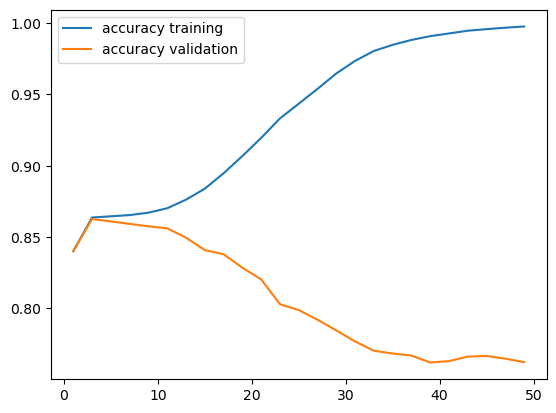

In [331]:
plt.plot(depth_params, acc_train, label='accuracy training')
plt.plot(depth_params, acc_val,label='accuracy validation')
plt.legend();

In [344]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=6, random_state=42)
).fit(X_train, y_train)
model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Transaction_Type', 'Merchant_Category'],
                                mapping=[{'col': 'Transaction_Type',
                                          'data_type': dtype('O'),
                                          'mapping': Online_Purchase    1
ATM_Withdral       2
NaN               -2
dtype: int64},
                                         {'col': 'Merchant_Category',
                                          'data_type': dtype('O'),
                                          'mapping': Airtime Top-up            1
 Financial Services       2
Event Ticket              3
Travel and Hotel          4
Invoice Payment           5
Shopping                  6
Cable Subscription        7
Betting and Lottery       8
Utilities                 9
prepaid Card Services    10
Product and Services     11
 Clothing                12
Mobile Money             13
School Fees              14
 Electronics             15
 Retail 

In [345]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)

print('accuracy training:', acc_train.round(4))
print('accuracy validation:', acc_val.round(4))

accuracy training: 0.8647
accuracy validation: 0.8611


In [346]:
acc_test = model.score(X_test, y_test)


print('accuracy test:', acc_test.round(4))

accuracy test: 0.8709


* here both the training and validation set did well and beat the baseline as expect
* the test set a great job by beating the baseline and also getting an accuracy score that is higher than that of the training and vauldation set.

### Building a decision tree classifier  Tree.
This tree start from the impurity/unclean node in the model and breakdown all the impure/unclean nodes to a pure/clean form.

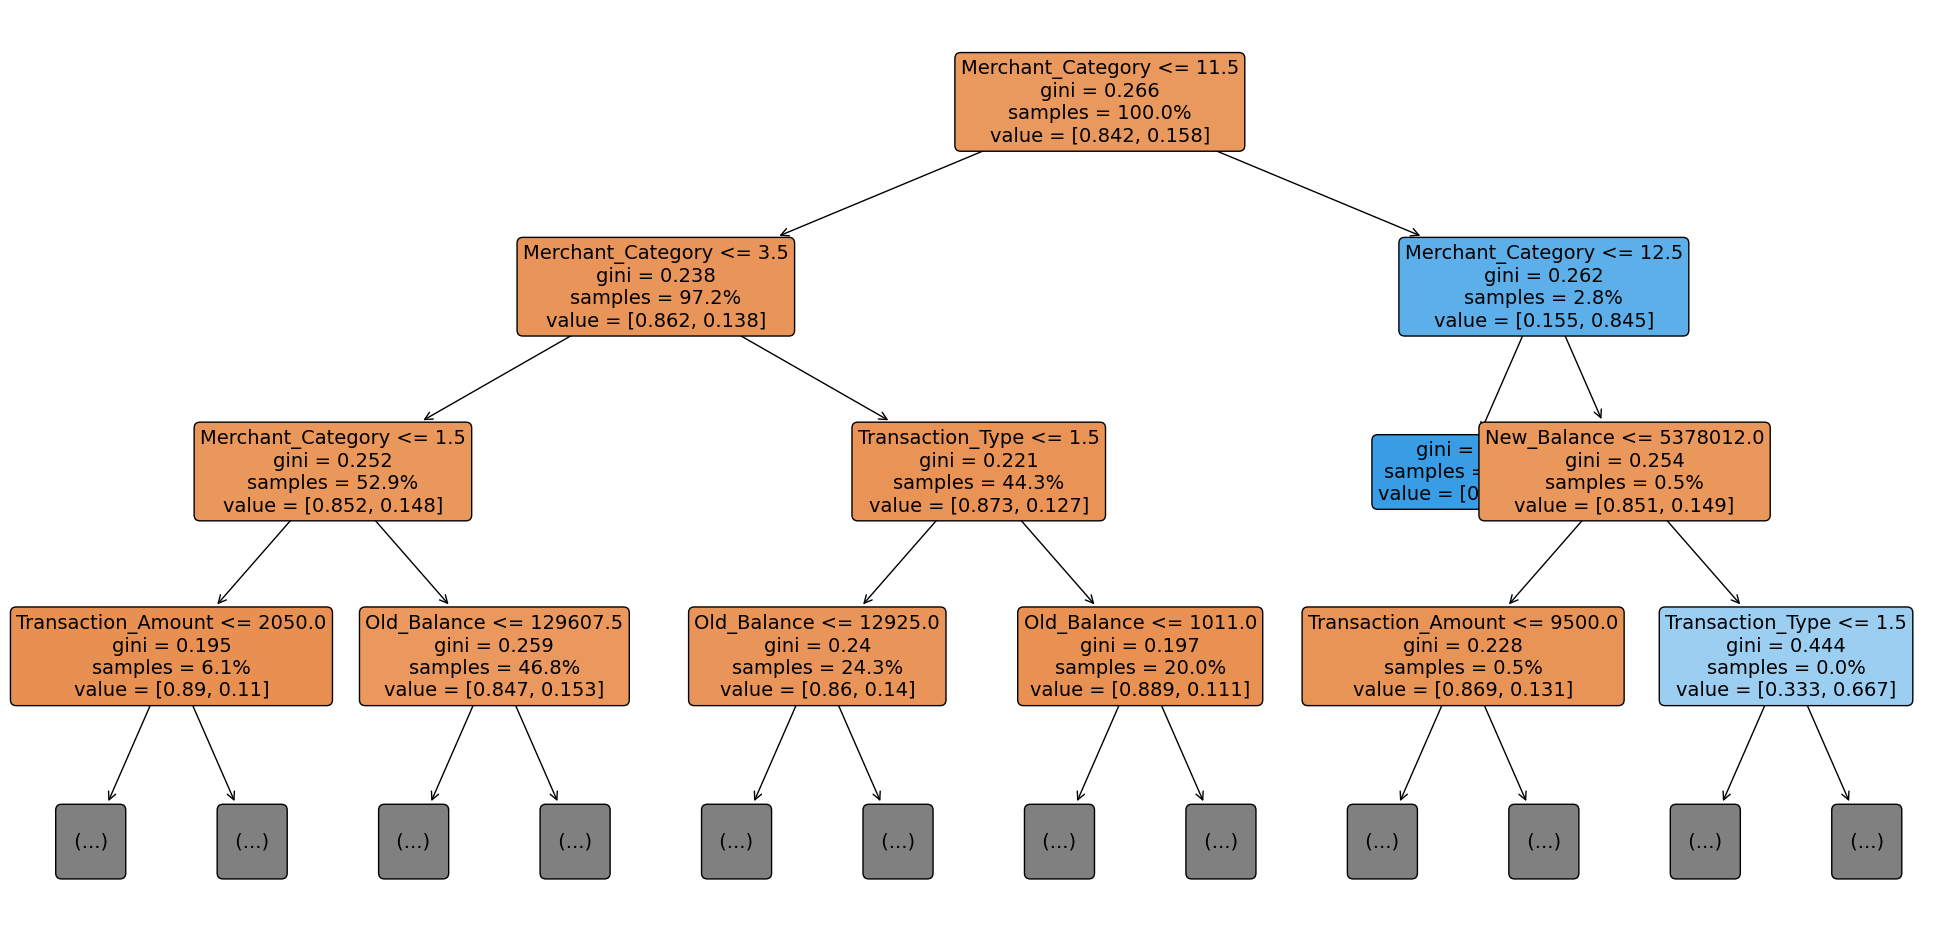

In [227]:
fig, ax= plt.subplots(figsize=[25, 12])
plot_tree(
    decision_tree= model.named_steps['decisiontreeclassifier'],
    feature_names=X_train.columns,
    filled = True,
    rounded = True,
    proportion = True,
    max_depth = 3,
    fontsize = 14,
    ax = ax
);

## Communication.

In [228]:
feature_names = X_train.columns
importances =  model.named_steps["decisiontreeclassifier"].feature_importances_

print("feature:", feature_names[:3])
print("importance:", importances[:3])

feature: Index(['Old_Balance', 'Transaction_Amount', 'New_Balance'], dtype='object')
importance: [0.03061493 0.0063611  0.02537861]


In [229]:
df_test = pd.Series(importances, index=feature_names).sort_values()
df_test.tail()

Transaction_Amount    0.006361
Transaction_Type      0.010028
New_Balance           0.025379
Old_Balance           0.030615
Merchant_Category     0.927617
dtype: float64

(0.0, 1.0)

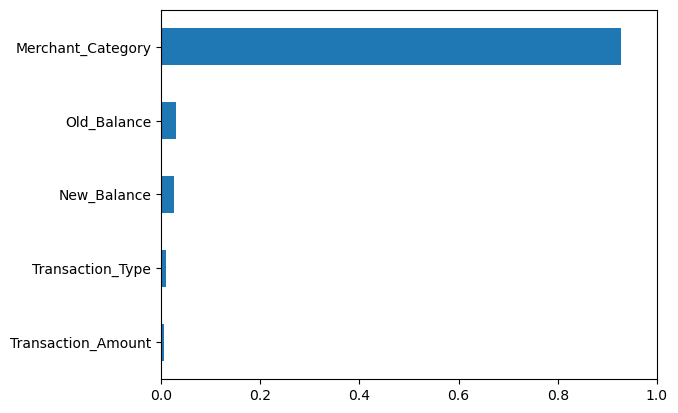

In [230]:
df_test.plot(kind="barh")
plt.xlim([0, 1])

The above diagram shows all features from the feature names and there level of impurity as shown on the decision tree earier.
* merchant catergory has the highest impure node in the model, with over 92.77% impure node.
* old_balance comes next with 3% impure node
* new_balance has 2% impure node
* transaction type with 1% and
* Transaction amount comes la